In [1]:
from torch_geometric.data import Data
%load_ext autoreload
%autoreload 1
%aimport gnn_tracking_hpo.trainable
from gnn_tracking_hpo.trainable import PretrainedECTCNTrainable, ECTrainable
from gnn_tracking.postprocessing.dbscanscanner import dbscan
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('sss1.mplstyle')



In [2]:
from gnn_tracking_hpo.defaults import legacy_config_compatibility, \
    suggest_default_values

from gnn_tracking_hpo.util.paths import get_config

config = legacy_config_compatibility(get_config("ec", "613118cb"))

suggest_default_values(config, hc="none")

[20:21:21 HPO] DEBUG: Loading config from /home/kl5675/ray_results/ec/ContinuedECTrainable_613118cb_1_val_batch_size=5,batch_size=5,cycliclr_gamma=1,cycliclr_mode=triangular2,cycliclr_step_size_down=1_2023-05-04_15-48-20/params.json


In [3]:
config["_val_batch_size"] = 1 # !!!!!!!!!!!!!

In [4]:
trainable = ECTrainable(config)

[20:21:21 HPO] INFO: I'm running on a node with job ID=48063026
[20:21:21 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[20:21:21 HPO] INFO: The ID of my dispatcher is 0
[20:21:21 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[20:21:21 HPO] DEBUG: Got config
┌────────────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size                    │ 1                                        │
│ batch_size                         │ 5                                        │
│ cycliclr_gamma                     │ 1                                        │
│ cycliclr_mode                      │ triangular2                              │
│ cycliclr_step_size_down            │ 1200                                     │
│ cycliclr_step_size_up              │ 1200                                     │
│ ec_epoch                           │ -1             

In [5]:
from gnn_tracking_hpo.util.paths import find_checkpoint

trainable.load_checkpoint(str(find_checkpoint("ec", "613118cb", -1)))

[20:21:26 HPO] DEBUG: Loading checkpoint from /home/kl5675/ray_results/ec/ContinuedECTrainable_613118cb_1_val_batch_size=5,batch_size=5,cycliclr_gamma=1,cycliclr_mode=triangular2,cycliclr_step_size_down=1_2023-05-04_15-48-20/checkpoint_000001/checkpoint.pt


In [6]:
import torch_geometric
%aimport gnn_tracking.analysis
from gnn_tracking.analysis.graphs import get_track_graph_info, get_track_graph_info_from_data


In [19]:
thresholds = np.linspace(0, 1., 100)

In [20]:
%aimport gnn_tracking.analysis.edge_classification
from gnn_tracking.analysis.edge_classification import collect_all_ec_stats

In [21]:

df = collect_all_ec_stats(
    model=trainable.trainer.model,
    data_loader=trainable.trainer.val_loader,
    thresholds=thresholds,
    n_batches=10,
)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: Type

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:

import pandas as pd


In [16]:
import pandas as pd

def get_graph_construction_connectivity(data: Data, pt_thld=0.9):
    return get_track_graph_info_from_data(data, w=torch.ones(data.edge_index.shape[1]), threshold=0.5, pt_thld=pt_thld)
    # gx = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)
    # particle_ids = data.particle_id[
    #     (data.particle_id > 0) & (data.pt > pt_thld)
    # ].unique()
    # results = []
    # for pid in particle_ids:
    #     results.append(get_track_graph_info(gx, data.particle_id, pid.item()))
    # return pd.DataFrame(
    #     results,
    #     columns=[
    #         "pid",
    #         "n_hits",
    #         "n_segments",
    #         "n_hits_largest_segment",
    #         "distance_largest_segments",
    #         "n_hits_largest_component",
    #     ],
    # )

In [34]:
summarize_track_graph_info(get_graph_construction_connectivity(next(iter(trainable.trainer.val_loader.dataset)), pt_thld=0.9))

{'frac_segment100': 0.8656716417910447,
 'frac_component100': 0.9253731343283582,
 'frac_segment50': 1.0,
 'frac_component50': 1.0,
 'frac_segment75': 0.9104477611940298,
 'frac_component75': 0.9552238805970149,
 'n_segments': 1.1791044776119404,
 'frac_hits_largest_segment': 0.9536010424070125,
 'frac_hits_largest_component': 0.9774816394219379}

In [33]:
summarize_track_graph_info(get_graph_construction_connectivity(next(iter(trainable.trainer.val_loader)), pt_thld=0.9))

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: Type

{'frac_segment100': 0.6993243243243243,
 'frac_component100': 0.7432432432432432,
 'frac_segment50': 0.9831081081081081,
 'frac_component50': 0.9864864864864865,
 'frac_segment75': 0.7635135135135135,
 'frac_component75': 0.8006756756756757,
 'n_segments': 1.3885135135135136,
 'frac_hits_largest_segment': 0.8808474183474185,
 'frac_hits_largest_component': 0.9000036281286281}

In [11]:
from gnn_tracking.analysis.graphs import summarize_track_graph_info
from torch.utils.data import RandomSampler
from gnn_tracking.utils.loading import TrackingDataset
import torch

def get_graph_construction_connectivity_from_path(path, pt_thld=0.9, n_samples=10):
    ds = TrackingDataset(path)
    generator = torch.Generator()
    generator.manual_seed(0)
    loader = torch_geometric.data.DataLoader(ds, batch_size=1, sampler=RandomSampler(ds, replacement=True, num_samples=n_samples, generator=generator))
    results = []
    for data in loader:
        results.append(summarize_track_graph_info(get_track_graph_info_from_data(data, w=torch.ones(data.edge_index.shape[1]), threshold=0.5, pt_thld=pt_thld)))
    df = pd.DataFrame.from_records(results)
    averaged = {
        key: df[key].mean() for key in df.columns
    } | {
        f"{key}_err": df[key].std() / np.sqrt(len(df)) for key in df.columns
    }
    return averaged

In [12]:
get_graph_construction_connectivity_from_path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v1/part_9/", n_samples=10)

[19:44:30] INFO: DataLoader will load 32000 graphs (out of 32000 available).
[19:44:30] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v1/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v1/part_9/data29999_s9.pt
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'frac_segment100': 0.8564237334521516,
 'frac_component100': 0.8987324539671793,
 'frac_segment50': 0.9942145333936379,
 'frac_component50': 0.9971185737976782,
 'frac_segment75': 0.917251154552677,
 'frac_component75': 0.9547574648314958,
 'n_segments': 1.1539473139756453,
 'frac_hits_largest_segment': 0.9548510438053374,
 'frac_hits_largest_component': 0.974146412104365,
 'frac_segment100_err': 0.014115264099647862,
 'frac_component100_err': 0.009759106304793097,
 'frac_segment50_err': 0.0031432889256739712,
 'frac_component50_err': 0.0019225036574811907,
 'frac_segment75_err': 0.012156441371611868,
 'frac_component75_err': 0.011484129313748833,
 'n_segments_err': 0.013238421683500633,
 'frac_hits_largest_segment_err': 0.004921189459116386,
 'frac_hits_largest_component_err': 0.004044946918825599}

In [16]:
df.loc[0]

threshold                         -1.000000
acc                                0.031506
TPR                                1.000000
TNR                                0.000000
FPR                                1.000000
FNR                                0.000000
balanced_acc                       0.500000
F1                                 0.061087
MCC                                0.000000
acc_thld                           0.161699
TPR_thld                           1.000000
TNR_thld                           0.000000
FPR_thld                           1.000000
FNR_thld                           0.000000
balanced_acc_thld                  0.500000
F1_thld                            0.278383
MCC_thld                           0.000000
frac_segment100                    0.699324
frac_component100                  0.743243
frac_segment50                     0.983108
frac_component50                   0.986486
frac_segment75                     0.763514
frac_component75                

In [22]:
from gnn_tracking.analysis.edge_classification import ThresholdTrackInfoPlot
%matplotlib notebook
ttip = ThresholdTrackInfoPlot(df)
ttip.plot()

<IPython.core.display.Javascript object>

In [39]:
from sklearn.manifold import TSNE
import torch

%aimport gnn_tracking
%aimport gnn_tracking.analysis.latent
import gnn_tracking
import gnn_tracking.analysis
import gnn_tracking.analysis.latent
from gnn_tracking.analysis.latent import SelectedPidsPlot

In [122]:
def get_spp_input(trainer, idx):
    data = trainer.val_loader.dataset[idx]
    trainer.model.eval()
    with torch.no_grad():
        model_output = trainer.evaluate_model(data)
    x = model_output["x"]
    pid = model_output["particle_id"]
    labels = dbscan(x)
    x_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(x)
    return {
        "condensation_space": x[:, :2],
        "particle_id": pid,
        "labels": torch.Tensor(labels),
        "ec_hit_mask": model_output["ec_hit_mask"],
        "input_node_features": data.x,
    }, data

In [123]:
spp_input, data = get_spp_input(trainable.trainer, 0)

In [130]:
import pandas as pd
pd.Series(data.particle_id).value_counts()

0                     153
549442178196176896     17
621502589732651008     15
409832788770947072     15
648522538229432320     15
                     ... 
607988492315656192      1
22524182906544130       1
364792119589613570      1
837674959546359810      1
49542138521714688       1
Length: 466, dtype: int64

In [139]:
random_pids = np.random.choice(spp_input["particle_id"][(spp_input["particle_id"] > 0) & (data.pt > 0.9)], 7, replace=False)

In [131]:
random_pids

array([806146738481004544, 553943441361338368,                  0,
       806146738481004544, 553943441361338368, 306251990206251008,
       607993027801120768])

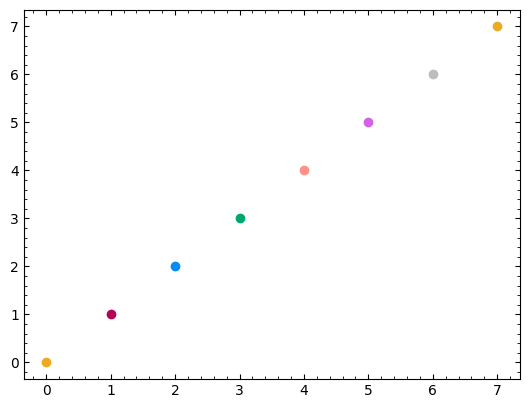

In [142]:
%matplotlib inline
fig, ax = plt.subplots()
for i in range(8):
    ax.scatter([i], [i])

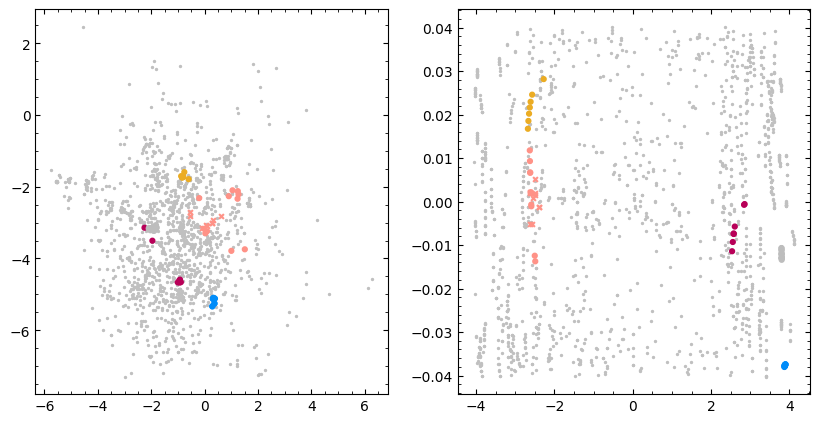

In [140]:
spp = SelectedPidsPlot(**spp_input, selected_pids=torch.Tensor(random_pids))
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
spp.plot_other_hit_latent(axs[0])
spp.plot_selected_pid_latent(axs[0])
spp.plot_collateral_latent(axs[0])
spp.plot_other_hit_ep(axs[1])
spp.plot_selected_pid_ep(axs[1])
spp.plot_collateral_ep(axs[1])

In [103]:
from gnn_tracking.analysis.graphs import get_track_graph_info_from_data

tgi_df = get_track_graph_info_from_data(data, trainable.trainer.model._gtcn.ec(data)["W"], threshold=trainable.trainer.model._gtcn.threshold)

In [104]:
tgi_df.set_index("pid")

,n_hits,n_segments,n_hits_largest_segment,distance_largest_segments,n_hits_largest_component
pid,,,,,
4521535410798592,11,1,11,0.0,11
4532942843936768,1,1,1,0.0,1
9012490654449664,4,2,3,inf,3
9036748629737472,9,1,9,0.0,9
22521571549642752,5,1,5,0.0,5
...,...,...,...,...,...
774619616944062464,1,1,1,0.0,1
806146738481004544,14,1,14,0.0,14
837679701173469184,3,3,1,inf,1


In [110]:
tgi_df.loc[4532942843936768]

KeyError: 4532942843936768

In [106]:
random_pids.tolist()

[94577035283791872,
 409829421516587008,
 432347076056055808,
 517915606415048704,
 72095252311179264,
 9012490654449664,
 283737496762712064]

In [109]:
4532942843936768 in tgi_df["pid"].to_list()

True